# Complete perception pipeline with examples and analysis

In [1]:
import sys
import json
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from typing import Dict, List, Tuple
import pprint

from pathlib import Path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

Perception componetns

In [2]:
from perception.detector import Detector, HybridDetector
from perception.box_segmenter import BoxSegmenter
from perception.depth_estimator import DepthEstimator, attach_depth_to_detections
from perception.postprocess import resolve_mask_overlaps_by_depth
from perception.attribute_extractor import AttributeExtractor

In [3]:
def load_clevr_data(num_samlples : int = 3):
    random.seed(42)
    clevr_jsonl_path = project_root / "datasets" / "converted" / "clevr" / "clevr_val.jsonl"
    samples = []
    with open(clevr_jsonl_path, 'r') as f:
        for line in f:
            data = json.loads(line)
            if data["image_id"] not in [sample["image_id"] for sample in samples]:
                samples.append(data)
            if len(samples) >= num_samlples * 3 : break

    return random.sample(samples, num_samlples)

Example of jsonl file

In [4]:
example_data = load_clevr_data(1)[0]
pprint.pprint(example_data)

{'answer': 'metal',
 'dataset': 'clevr',
 'image_id': 'CLEVR_val_000002',
 'image_path': 'datasets/clevr/images/val/CLEVR_val_000002.png',
 'metadata': {'image_index': 2,
              'question_family_index': 82,
              'question_index': 20},
 'program': [{'function': 'scene', 'inputs': [], 'value_inputs': []},
             {'function': 'filter_color',
              'inputs': [0],
              'value_inputs': ['gray']},
             {'function': 'filter_material',
              'inputs': [1],
              'value_inputs': ['rubber']},
             {'function': 'filter_shape',
              'inputs': [2],
              'value_inputs': ['cylinder']},
             {'function': 'unique', 'inputs': [3], 'value_inputs': []},
             {'function': 'relate', 'inputs': [4], 'value_inputs': ['left']},
             {'function': 'filter_material',
              'inputs': [5],
              'value_inputs': ['rubber']},
             {'function': 'unique', 'inputs': [6], 'value_inputs': 

## Detector

In [12]:
detector = HybridDetector()
data = load_clevr_data(6)

detections : Dict[str, List[Dict]] = {}

for d in data:
    img_path = project_root / d["image_path"]
    detection = detector.detect(img_path)
    img_id = d["image_id"]
    detections[f"{img_id}"] = detection

random_key = random.choice(list(detections.keys()))
pprint.pprint(detections[random_key])

[{'bbox': [136.49346923828125,
           131.67816162109375,
           224.86990356445312,
           241.29832458496094],
  'class_id': -1,
  'class_name': 'sam_only',
  'confidence': 0.9628819227218628,
  'source': 'sam_only'},
 {'bbox': [45.40193557739258,
           125.1756591796875,
           88.026123046875,
           166.1370849609375],
  'class_id': -1,
  'class_name': 'sam_only',
  'confidence': 0.9567687511444092,
  'source': 'sam_only'},
 {'bbox': [196.5560760498047,
           58.124027252197266,
           250.2773895263672,
           111.84574890136719],
  'class_id': -1,
  'class_name': 'sam_only',
  'confidence': 0.953717052936554,
  'source': 'sam_only'},
 {'bbox': [316.4446105957031,
           74.76844024658203,
           384.566650390625,
           152.9677276611328],
  'class_id': -1,
  'class_name': 'sam_only',
  'confidence': 0.9374672770500183,
  'source': 'sam_only'},
 {'bbox': [150.65159606933594,
           92.05806732177734,
           179.7830657958

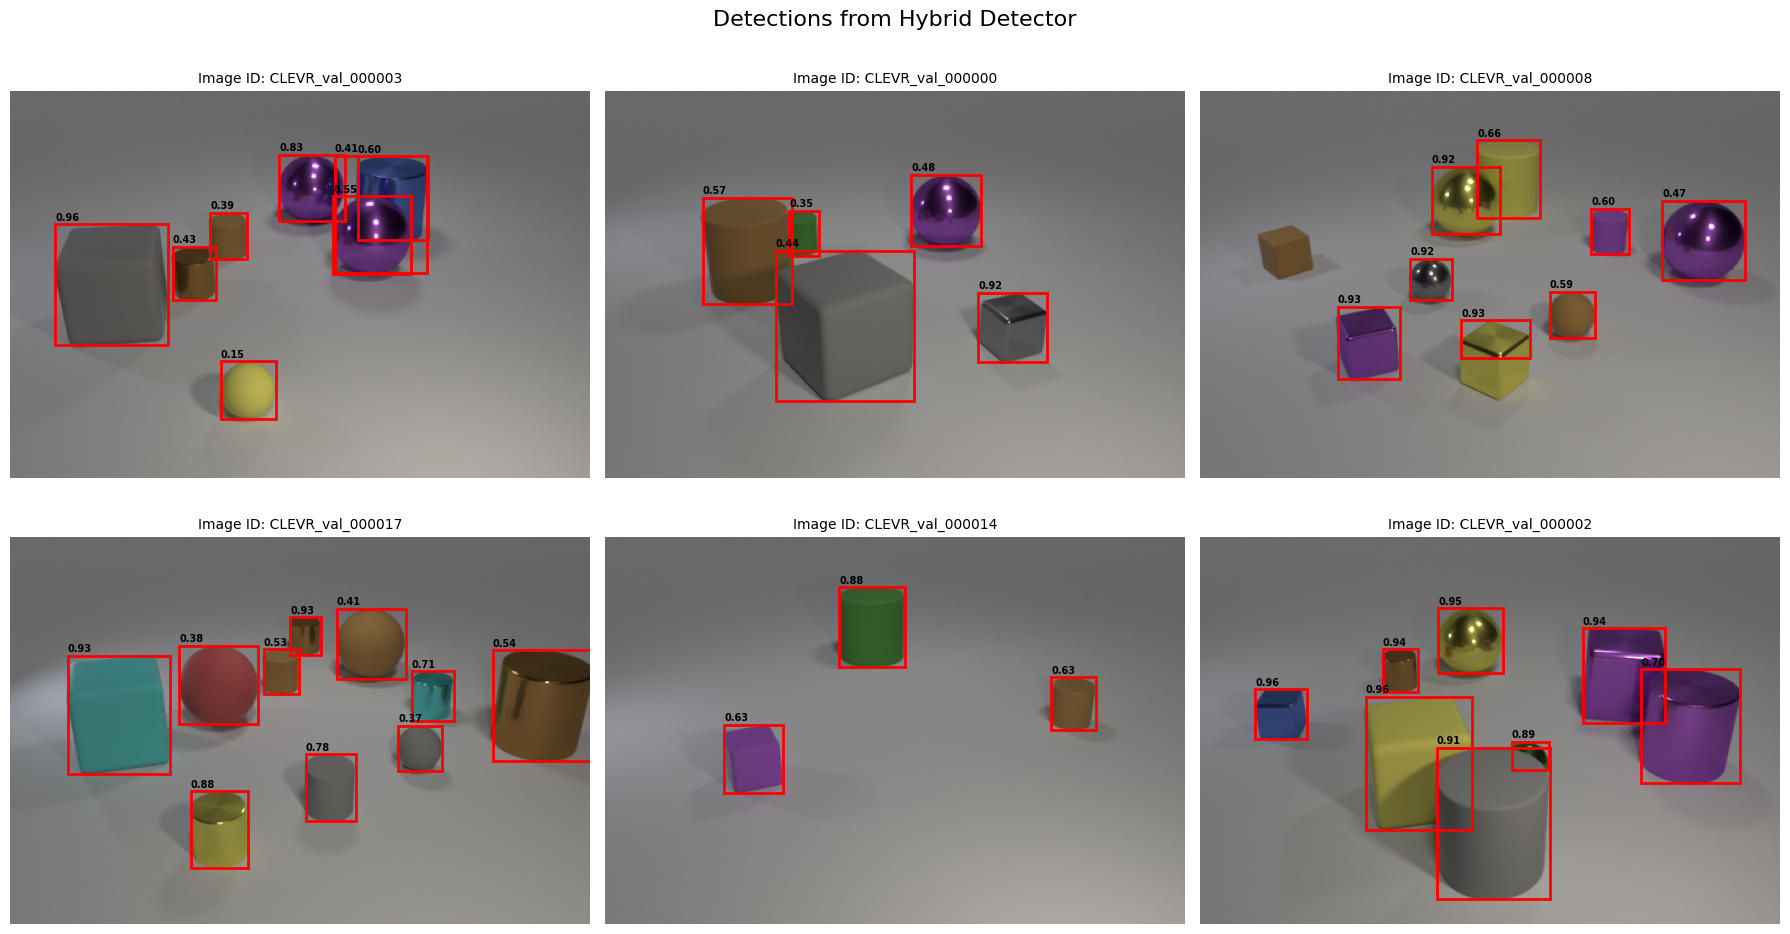

In [ ]:
import math
import matplotlib.patches as patches

img_ids = list(detections.keys())

n_images = len(img_ids)
n_cols = 3
n_rows = math.ceil(n_images / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

id_to_path = {d["image_id"]: d["image_path"] for d in data}

for idx, img_id in enumerate(img_ids):
    img_path = project_root / id_to_path[img_id]
    img = np.array(Image.open(img_path).convert("RGB"))

    ax = axes[idx]
    ax.imshow(img)
    ax.set_title(f"Image ID: {img_id}")
    for det in detections[img_id]:
        x1, y1, x2, y2 = det["bbox"]
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        label = f"{det['confidence']:.2f}"
        ax.text(x1, y1 - 3, label, color='black', fontsize=7, weight='bold')

    ax.set_title(f"Image ID: {img_id}", fontsize=10)
    ax.axis('off')
    
plt.suptitle("Detections from Hybrid Detector", fontsize=16)
plt.tight_layout()
plt.show()

## Segmenter